In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import statsmodels.stats.multitest as smm
from scipy import stats
import seaborn as sns

pd.options.mode.chained_assignment = None

#makes viewing pandas tables better
pd.set_option('display.max_colwidth', 0)

In [2]:
#CHANGE AS NEEDED

#Set this to the same as it was in BarSeq_counting.ipynb
output_dir = 'TNSeq_barseq_outputs'

### RHseq parameters


    ctrl_temp and exp_temp: Control and experimental temperatures, as written in the sample names for the metafile from BarSeq_counting.ipynb

    sp1, sp2: Species prefixes as in the TNseq annotation file (e.g. K. lactis is Kl) - must be the same length for both species

    include_promoters: If False, only analyze barcodes which landed in the CDS of a gene. If True, analyze barcodes which landed in the promoter and CDS.

    collapsed: 
    
        If collapsed = False, fitness ratios will be calculated separately for each experimental replicate: 
    
$$log_{2}(\frac{experimental\;replicate\;1\;normalized\;read\;count}{control\;average\;normalized\;read\;count});\; log_{2}(\frac{experimental\;replicate\;2\;normalized\;read\;count}{control\;average\;normalized\;read\;count}),\; etc.$$


        If collapsed = True, the fitness ratio will be caluclated from the average of experimental replicates: 
        
$$log_{2}\frac{experimental\;replicates\;AVERAGE\;normalized\;read\;count}{control\;average\;normalized\;read\;count}$$



    filter_strategy:

        If filter_strategy = 'coeff':
        Barcode will be kept if in at least one temperature, the coefficient of variation is LESS THAN than coeff_var_cutoff.

        If filter_strategy = 'reads':
        Barcode will be kept if in at least one temperature, the average normalized read count is GREATER THAN  norm_reads_cutoff.

        If filter_strategy = 'both':
        Barcode will be kept if it passes BOTH read count and coefficient of variation filters as described above.

    max_coeff_var_per_barcode: Maximum coefficient of variation of a barcode in a given temperature 
    
    min_norm_reads_per_barcode: Minimum average normalized read count for a barcode in a given temperature
    
    min_inserts_per_allele: Minimum number of barcodes which were inserted into each allele of a gene
    
    max_coeffvar_per_allele: Maximum coefficient of variation of fitness ratios for each allele of a gene

For reference, the following parameter set was used in the Saccharomyces Barseq paper:

    collapsed = False
    include_promoters = False

    filter_strategy = 'both'
    max_coeff_var_per_barcode = 2
    min_norm_reads_per_barcode = 1.1

    min_inserts_per_allele = 3
    max_coeffvar_per_allele = 10


In [3]:
#CHANGE AS NEEDED

ctrl_temp = '28C'
exp_temp = '42C'

sp1, sp2 = 'kl', 'km'
prefix_length = len(sp1)

include_promoters = False
collapsed = False

filter_strategy = 'both'
max_coeff_var_per_barcode = 2
min_norm_reads_per_barcode = 1.1

min_inserts_per_allele = 3
max_coeffvar_per_allele = 10

### Load Barseq count data

In [11]:
df = pd.read_csv('{}/poolCount.txt'.format(output_dir), sep='\t')
df.head()

,barcode,scaffold,pos,gene,28C_1,28C_2,28C_3,28C_4,28C_5,28C_6,42C_1,42C_2,42C_3,42C_4,42C_5,42C_6
0,CGATATGTATTGTAGTGTGA,chr12,533978,NaN,22,0,0,18,8,8,2,0,0,3,0,2
1,GTTCCTCATACAGATCCACA,chr8,1469433,NaN,215,268,135,147,192,211,91,111,86,38,17,269
2,AGTCTCTCCGTGGCAAGTAG,chr1,938226,NaN,63,105,83,25,67,25,14,23,32,4,6,50
3,GCCGTTTAGCTCCAACTCCA,chr2,1190978,NaN,0,26,24,38,14,25,4,25,21,0,0,21
4,TCAGCGGGTCTTACATACAT,chr11,1166275,kmYGL141W,592,719,541,486,691,467,196,296,197,144,69,685


In [12]:
ctrl_cols = [col for col in df.columns if ctrl_temp in col]
exp_cols = [col for col in df.columns if exp_temp in col]
competition_cols = ctrl_cols + exp_cols

In [13]:
#check that these look correct
print('Control columns: {}'.format(ctrl_cols))
print('Experimental columns: {}'.format(exp_cols))

Control columns: ['28C_1', '28C_2', '28C_3', '28C_4', '28C_5', '28C_6']
Experimental columns: ['42C_1', '42C_2', '42C_3', '42C_4', '42C_5', '42C_6']


### Step 1: Normalize read counts

Normalized read count = (raw read count * average total mapped reads across replicates) / total mapped reads for replicate 

In [14]:
total_mapped_reads = {}

for col in competition_cols:
    total_mapped_reads[col] = sum(df[col])
    
avg_total_mapped_reads = np.mean(list(total_mapped_reads.values()))

for col in competition_cols:
    df[col+'_normalized_read_count'] = avg_total_mapped_reads*df[col]/total_mapped_reads[col]

In [15]:
df.head()

,barcode,scaffold,pos,gene,28C_1,28C_2,28C_3,28C_4,28C_5,28C_6,...,28C_3_normalized_read_count,28C_4_normalized_read_count,28C_5_normalized_read_count,28C_6_normalized_read_count,42C_1_normalized_read_count,42C_2_normalized_read_count,42C_3_normalized_read_count,42C_4_normalized_read_count,42C_5_normalized_read_count,42C_6_normalized_read_count
0,CGATATGTATTGTAGTGTGA,chr12,533978,NaN,22,0,0,18,8,8,...,0.000000,16.114655,4.853323,6.642622,3.813076,0.000000,0.000000,10.371215,0.000000,1.375145
1,GTTCCTCATACAGATCCACA,chr8,1469433,NaN,215,268,135,147,192,211,...,101.493772,131.603019,116.479761,175.199164,173.494962,155.406194,177.681451,131.368727,110.782120,184.956981
2,AGTCTCTCCGTGGCAAGTAG,chr1,938226,NaN,63,105,83,25,67,25,...,62.399875,22.381466,40.646583,20.758195,26.691533,32.201283,66.114028,13.828287,39.099572,34.378621
3,GCCGTTTAGCTCCAACTCCA,chr2,1190978,NaN,0,26,24,38,14,25,...,18.043337,34.019828,8.493316,20.758195,7.626152,35.001395,43.387331,0.000000,0.000000,14.439021
4,TCAGCGGGTCTTACATACAT,chr11,1166275,kmYGL141W,592,719,541,486,691,467,...,406.726894,435.095694,419.205807,387.763078,373.681456,414.416516,407.014487,497.818333,449.645075,470.987109


### Step 2: Filter barcodes

Drop barcodes with no reads in any Barseq competitions, barcodes in noncoding regions, and barcodes mapping to the plasmid.

In [16]:
print('Beginning with {} barcodes seen in the TNseq pool'.format(df.shape[0]))
print()

#drop barcodes with no reads in any competition
total_reads = df[competition_cols].sum(axis=1)
df = df[total_reads >= 1]
print('Dropping barcodes which were seen in the TNseq pool, but not in any Barseq competitions.')
print('{} barcodes remain for Barseq analysis.'.format(df.shape[0]))
print()

#drop barcodes with only 1 read across competitions
total_reads = df[competition_cols].sum(axis=1)
df = df[total_reads > 1]
print('Dropping barcodes with only 1 read across competitions.')
print('{} barcodes remain for Barseq analysis.'.format(df.shape[0]))
print()

#drop noncoding barcodes
df = df[~df['gene'].isna()]
print('Dropping barcodes in noncoding regions.')
print('{} barcodes remain for Barseq analysis.'.format(df.shape[0]))
print()


#drop barcodes mapping to plasmid
df = df[df['gene']!='plasmid']
print('Dropping barcodes mapping to the plasmid.')
print('{} barcodes remain for Barseq analysis.'.format(df.shape[0]))
print()

Beginning with 270652 barcodes seen in the TNseq pool

Dropping barcodes which were seen in the TNseq pool, but not in any Barseq competitions.
86856 barcodes remain for Barseq analysis.

Dropping barcodes with only 1 read across competitions.
81685 barcodes remain for Barseq analysis.

Dropping barcodes in noncoding regions.
15688 barcodes remain for Barseq analysis.

Dropping barcodes mapping to the plasmid.
15688 barcodes remain for Barseq analysis.



### Step 3: Calculate average of normalized read counts and coefficient of variation across replicates for each temperature.

In [17]:
#replace 0 with NaN so 0 values are not counted in calculating means

ctrl_norm_cols = [col + '_normalized_read_count' for col in ctrl_cols]
exp_norm_cols = [col + '_normalized_read_count' for col in exp_cols]

df[ctrl_norm_cols+exp_norm_cols] = df[ctrl_norm_cols+exp_norm_cols].replace(0.0, np.nan)

In [18]:
df[ctrl_temp+'_avg_normalized_read_count'] = df[ctrl_norm_cols].mean(axis=1)
df[ctrl_temp+'_coeffvar'] = df[ctrl_norm_cols].std(axis=1)/df[ctrl_temp+'_avg_normalized_read_count']

df[exp_temp+'_avg_normalized_read_count'] = df[exp_norm_cols].mean(axis=1)
df[exp_temp+'_coeffvar'] = df[exp_norm_cols].std(axis=1)/df[exp_temp+'_avg_normalized_read_count']


print('Mean coeff var for {} = {}.'.format(ctrl_temp, df[ctrl_temp+'_coeffvar'].mean()))
print('Mean coeff var for {} = {}.'.format(exp_temp, df[exp_temp+'_coeffvar'].mean()))

Mean coeff var for 28C = 0.6429773079842185.
Mean coeff var for 42C = 0.676786616548283.


In [19]:
df.head()

,barcode,scaffold,pos,gene,28C_1,28C_2,28C_3,28C_4,28C_5,28C_6,...,42C_1_normalized_read_count,42C_2_normalized_read_count,42C_3_normalized_read_count,42C_4_normalized_read_count,42C_5_normalized_read_count,42C_6_normalized_read_count,28C_avg_normalized_read_count,28C_coeffvar,42C_avg_normalized_read_count,42C_coeffvar
4,TCAGCGGGTCTTACATACAT,chr11,1166275,kmYGL141W,592,719,541,486,691,467,...,373.681456,414.416516,407.014487,497.818333,449.645075,470.987109,416.335008,0.050702,435.593829,0.104803
7,GGTATTATTACAAGTACTGG,chr7,1204635,kmYMR004W,192,317,222,126,263,189,...,53.383065,82.603292,64.047965,89.883866,19.549786,161.579519,153.911498,0.188354,78.507915,0.607236
13,TGCTTTCACTACGTTATAGT,chr9,657272,kmYLR305C,0,0,0,0,0,18,...,NaN,NaN,NaN,NaN,NaN,NaN,14.945900,NaN,NaN,NaN
15,AGCTCAATGTTTATCAAGAG,chr6,196790,klYBR259W,262,375,255,146,323,122,...,114.392282,187.607477,223.134846,231.623808,97.748929,244.775782,171.774874,0.276971,183.213854,0.343358
23,ATGGCCTTGTTGAGTCTACC,chr5,2150759,klYPL093W,0,0,0,0,6,0,...,NaN,NaN,10.330317,NaN,NaN,1.375145,3.639993,NaN,5.852731,1.081933


### Step 4: Calculate fitness ratios


For EACH experimental replicate: fitness ratio = log2( experimental rep normalized read count / control average normalized read count)

Drop barcodes where the average fitness ratio is NaN.

In [20]:
exp_norm_cols = [col for col in df.columns if exp_temp in col and 'normalized_read_count' in col]

for col in exp_norm_cols:
    new_col = col.replace('normalized_read_count','fitness_ratio')
    df.loc[:, new_col] = np.log2(df[col]/df[ctrl_temp+'_avg_normalized_read_count'])

In [21]:
#drop barcodes where log2(exp_avg/ctrl_avg) is NaN
print('Dropping {} barcodes where log2(exp_avg/ctrl_avg) is NaN.'.format(df[df['{}_avg_fitness_ratio'.format(exp_temp)].isna()].shape[0]))
df = df[~df['{}_avg_fitness_ratio'.format(exp_temp)].isna()]
print('{} barcodes remain for Barseq analysis.'.format(df.shape[0]))

Dropping 4609 barcodes where log2(exp_avg/ctrl_avg) is NaN.
11079 barcodes remain for Barseq analysis.


In [22]:
df.head()

,barcode,scaffold,pos,gene,28C_1,28C_2,28C_3,28C_4,28C_5,28C_6,...,28C_coeffvar,42C_avg_normalized_read_count,42C_coeffvar,42C_1_fitness_ratio,42C_2_fitness_ratio,42C_3_fitness_ratio,42C_4_fitness_ratio,42C_5_fitness_ratio,42C_6_fitness_ratio,42C_avg_fitness_ratio
4,TCAGCGGGTCTTACATACAT,chr11,1166275,kmYGL141W,592,719,541,486,691,467,...,0.050702,435.593829,0.104803,-0.155936,-0.006663,-0.032665,0.257874,0.111042,0.177943,0.065239
7,GGTATTATTACAAGTACTGG,chr7,1204635,kmYMR004W,192,317,222,126,263,189,...,0.188354,78.507915,0.607236,-1.527647,-0.897830,-1.264876,-0.775967,-2.976876,0.070143,-0.971191
15,AGCTCAATGTTTATCAAGAG,chr6,196790,klYBR259W,262,375,255,146,323,122,...,0.276971,183.213854,0.343358,-0.586529,0.127198,0.377397,0.431265,-0.813366,0.510942,0.093010
23,ATGGCCTTGTTGAGTCTACC,chr5,2150759,klYPL093W,0,0,0,0,6,0,...,NaN,5.852731,1.081933,NaN,NaN,1.504877,NaN,NaN,-1.404352,0.685174
29,ATAAGGATTGGGTTACCGAG,chr7,1042832,kmYKR054C,0,8,0,0,0,0,...,NaN,3.813076,NaN,-0.376484,NaN,NaN,NaN,NaN,NaN,-0.376484


In [23]:
#save to csv
df.to_csv('{}/barcode_counts_and_fitness_ratios_UNFILTERED.csv'.format(output_dir))

### Step 4: Filter barcodes by coefficient of variation and/or average of normalized read counts.

In [24]:
coeff_var_cols = [exp_temp+'_coeffvar', ctrl_temp+'_coeffvar']
avg_norm_reads_cols = [exp_temp+'_avg_normalized_read_count', ctrl_temp+'_avg_normalized_read_count']

#make a copy for filtering so we don't mess up the original dataframe
df_copy = df.copy()

if filter_strategy == 'coeff':    
    filtered_df = df_copy[df_copy[coeff_var_cols].apply(lambda x: x <= max_coeff_var_per_barcode, axis=1).sum(axis=1) >= 1]
    print('Dropping {} barcodes with coeff >= {} in at least one temperature.'.format(df.shape[0]-filtered_df.shape[0], max_coeff_var_per_barcode))
    
elif filter_strategy == 'reads':
    filtered_df = df_copy[df_copy[avg_norm_reads_cols].apply(lambda x: x >= min_norm_reads_per_barcode, axis=1).sum(axis=1) >= 1]
    print('Dropping {} barcodes with average normalized read count <= {} in at least one temperature.'.format(df.shape[0]-filtered_df.shape[0], min_norm_reads_per_barcode))

elif filter_strategy == 'both':
    coeff_filt = df[df[coeff_var_cols].apply(lambda x: x <= max_coeff_var_per_barcode, axis=1).sum(axis=1) >= 1]
    read_filt = df[df[avg_norm_reads_cols].apply(lambda x: x >= min_norm_reads_per_barcode, axis=1).sum(axis=1) >= 1]
    filtered_df = df[(df.index.isin(coeff_filt.index)) & (df.index.isin(read_filt.index))]
    print('Dropping {} barcodes with coeff >= {} and/or average normalized read count <= {} in at least one temperature.'.format(df.shape[0]-filtered_df.shape[0], max_coeff_var_per_barcode, min_norm_reads_per_barcode))

print('{} barcodes remain for Barseq analysis.'.format(filtered_df.shape[0]))

Dropping 1886 barcodes with coeff >= 2 and/or average normalized read count <= 1.1 in at least one temperature.
9193 barcodes remain for Barseq analysis.


In [25]:
output_file = '{}/barcode_counts_and_fitness_ratios_FILTERED.csv'.format(output_dir)

with open(output_file, 'w') as f:
    #write filter parameters to file
    f.write('# FILTER PARAMS: filter_strategy={}; max_coeff_var_per_barcode={}; min_norm_reads_per_barcode={}'.format(filter_strategy,max_coeff_var_per_barcode,min_norm_reads_per_barcode))
    #write remaining barcodes to file
    filtered_df.to_csv(f)

### Step 6: Filter by number of inserts in each gene/allele and coefficient of variation of inserts in each gene/allele.

Number of inserts means number of barcodes mapping to a given gene and allele.

Coefficient of variation of inserts means the coefficient of variation of 

Defaults from Melanie's scripts, change if needed.

In [26]:
#split annotation column into gene and allele columns
filtered_df['allele'] = filtered_df['gene'].str[:prefix_length]
filtered_df['gene_name'] = filtered_df['gene'].str[prefix_length:]

#gene names must be at least 3 characters long
filtered_df = filtered_df[filtered_df['gene_name'].str.len() >= 3]

In [27]:
#group barcodes by gene/allele and count number of inserts per allele
insert_counts_per_allele = filtered_df.groupby('gene_name')['allele'].value_counts().unstack(level=1)
insert_counts_per_allele.columns = [col+'_insert_counts' for col in insert_counts_per_allele.columns]

In [28]:
#group barcodes by gene/allele and calculate coefficient of variation of experimental/control average normalized read counts
def coeffvar(col):
    return np.std(col)/np.mean(col)

exp_ctrl_ratio = '{}/{}_avg_normalized_read_count'.format(exp_temp, ctrl_temp)
filtered_df[exp_ctrl_ratio] = filtered_df[exp_temp+'_avg_normalized_read_count']/filtered_df[ctrl_temp+'_avg_normalized_read_count']
coeff_var_by_allele = filtered_df.groupby(['gene_name', 'allele'])[exp_ctrl_ratio].apply(coeffvar).unstack(level=1)
coeff_var_by_allele.columns = [col+'_coeff_var' for col in coeff_var_by_allele.columns]

In [29]:
#merge inserts per allele and coeffvar data into one frame
inserts_per_allele = insert_counts_per_allele.merge(coeff_var_by_allele, left_index=True, right_index=True)
inserts_per_allele.head()

,kl_insert_counts,km_insert_counts,kl_coeff_var,km_coeff_var
gene_name,,,,
Scer_YGOB_ADL119W,1.0,NaN,0.000000,NaN
Scer_YGOB_Anc_7.495,1.0,NaN,0.000000,NaN
YAL001C,1.0,5.0,0.000000,0.577766
YAL002W,4.0,10.0,0.439696,0.880105
YAL008W,3.0,NaN,0.434166,NaN


In [30]:
print('Beginning with {} genes with at least one insertion in either species.'.format(inserts_per_allele.shape[0]))

inserts_per_allele_filtered_count = inserts_per_allele[(inserts_per_allele[sp1+'_insert_counts'] >= min_inserts_per_allele)
                                                 & (inserts_per_allele[sp2+'_insert_counts'] >= min_inserts_per_allele)]

print('Dropping {} genes with less than {} insertions per allele in one or both species.'.format(inserts_per_allele.shape[0]-inserts_per_allele_filtered_count.shape[0], min_inserts_per_allele))

inserts_per_allele_filtered = inserts_per_allele_filtered_count[(inserts_per_allele_filtered_count[sp1+'_coeff_var'] <= max_coeffvar_per_allele) 
                                                 & (inserts_per_allele_filtered_count[sp2+'_coeff_var'] <= max_coeffvar_per_allele)]

print('Dropping {} genes with coefficient of variation greater than {} in one or both species.'.format(inserts_per_allele_filtered_count.shape[0]-inserts_per_allele_filtered.shape[0], max_coeffvar_per_allele))


print('{} genes remain for analysis.'.format(inserts_per_allele_filtered.shape[0]))

Beginning with 2976 genes with at least one insertion in either species.
Dropping 2818 genes with less than 3 insertions per allele in one or both species.
Dropping 0 genes with coefficient of variation greater than 10 in one or both species.
158 genes remain for analysis.


In [31]:
#drop barcodes mapping to genes that didn't pass above filter
filtered_df = filtered_df[filtered_df['gene_name'].isin(inserts_per_allele_filtered.index)]

### Step 7: Calculate effect size, Mann Whitney U test and multiple hypothesis testing correction

Effect size = difference of fitness ratio means

In [32]:
def multiple_columns_to_list(df):
    
    ###take values from multiple columns (eg. fitness ratios from different replicates) and 
    ###combine into a single list
    
    val_list = []
    for col in df.columns:
        val_list += df[col].dropna().tolist()
    return val_list

fitness_ratio_columns = [col for col in filtered_df.columns if 'fitness_ratio' in col and 'avg' not in col]
fitness_ratios_by_allele = filtered_df.groupby(['gene_name', 'allele'])[fitness_ratio_columns].apply(multiple_columns_to_list).to_frame()
fitness_ratios_by_allele = fitness_ratios_by_allele.unstack(level=1)
fitness_ratios_by_allele_columns = [col + '_fitness_ratios' for col in fitness_ratios_by_allele.columns.get_level_values(1)]
fitness_ratios_by_allele.columns = fitness_ratios_by_allele_columns
fitness_ratios_by_allele.head()

,kl_fitness_ratios,km_fitness_ratios
gene_name,,
YAL002W,"[0.5151700540180278, -0.22576443860544776, -1.152693358977049, 0.003963920925007036, -0.6643642482798304, 0.8875280881384242, -2.836627680244507]","[-0.63131631258705, -0.0694656067780694, -2.3993664117640505, -0.7961180363712612, -1.0653579136692415, -0.032393184887225555, -0.5149365984366983, -2.944586660130731, -1.5108289053278705, -0.19345901903269938, -1.1466252202904952, -1.1009333236210106, 0.16627539500016517, 0.04646359188891874, 1.439441635855337, 0.31474176056762315, 2.5960408129468506, -0.09105857176248937, -0.5407711798597171, -1.2731907300383738, 0.005836411614587066, -2.1032717541433747, 1.971291886535405, -0.21890924446723903, -2.385524900327478, -2.2857756436194268, -0.21480155135841128]"
YAL016W,"[0.013536802249594982, 1.6519823251535692, 0.9834622666078365, 0.6321961480106817, 2.20651133349494, 0.6754947986991425, 0.12946600091658358, 0.9473883718297749, -1.0023370837622123, 2.510577557057903, 0.8297686059690011, 0.5958030332751362, 1.6400422112143342, -1.4879094659686953]","[-0.3172671795843301, -0.3808643998389437, 0.08525873531199095, -1.523266075804704, -1.3975427465376802, 2.6838705380094816, 0.5413280523200037, 2.8045549053369623, 1.5984383879326685, -1.2310589271925403, -0.11056700704822463, -1.9848436777812006, -3.4371986331366324]"
YAL041W,"[1.3430341617885286, 1.6487465236530732, 2.2434905213247824, 0.6345287642961057, -0.7316294397836707, 0.7980195296661534, 0.8740008597343606, -0.3508014950998744, -0.4479352020658336, 2.2796319056941354, 0.18541366067004458, 0.20689671450974298, -0.7133000715091597, -0.11707256738871424, -0.7133080384219915, -2.376775803486576]","[-1.4219075158279137, -0.5034942883031267, 0.6825375628738268, -0.7843905654613201, -1.1143575299421862]"
YAL054C,"[-2.55465735457289, -2.629294667232221, -1.232774962751075, -3.6551954081501243, -3.026029087149422]","[3.2084783511210953, -2.671081066192901, -2.3503641485806632, -2.871904173691734, 0.8037556206234866, 2.125371075774207, 1.6329851573700616, 0.15214411782340695, -1.3750537122234419, -0.7835453106200337, -1.77381023576308, -2.897804914609637]"
YBL037W,"[1.236392973896978, 0.7909219822383491, -2.7093253242937365, 0.3523221725639663, -1.8621147550451402, 0.5019868354866521]","[0.8569691805780701, 0.06701982443241293, -1.5885018110805589, 0.6215488327737841, 0.2638017045436751, 1.30052691320356, -0.2924744571110996, -0.8193894074229626, -0.3234992266998454]"


In [33]:
##Effect size

fitness_ratios_by_allele[sp1+'_mean'] = fitness_ratios_by_allele[fitness_ratios_by_allele_columns[0]].apply(np.mean, axis=0)
fitness_ratios_by_allele[sp2+'_mean'] = fitness_ratios_by_allele[fitness_ratios_by_allele_columns[1]].apply(np.mean, axis=0)
fitness_ratios_by_allele['effect_size'] = fitness_ratios_by_allele[sp1+'_mean'] - fitness_ratios_by_allele[sp2+'_mean']

In [34]:
##Mann Whitney U statistic
fitness_ratios_by_allele['MannWhitney_U'] = fitness_ratios_by_allele.apply(lambda x: 
                                     stats.mannwhitneyu(x[fitness_ratios_by_allele_columns[0]],
                                                        x[fitness_ratios_by_allele_columns[1]],
                                                       alternative='two-sided')[0], axis=1)
                                    
##Mann Whitney p value
fitness_ratios_by_allele['MannWhitney_p'] = fitness_ratios_by_allele.apply(lambda x: 
                                     stats.mannwhitneyu(x[fitness_ratios_by_allele_columns[0]],
                                                        x[fitness_ratios_by_allele_columns[1]],
                                                       alternative='two-sided')[1], axis=1)                            

In [35]:
##Correction for multiple hypothesis testing
fitness_ratios_by_allele['MannWhitney_p_adj'] = smm.multipletests(fitness_ratios_by_allele['MannWhitney_p'].tolist(),
                                                                  method='fdr_bh')[1]

In [36]:
##merge with insert count and coefficient of variation data above

fitness_ratios_by_allele = fitness_ratios_by_allele.merge(inserts_per_allele_filtered, left_index=True, right_index=True)
fitness_ratios_by_allele = fitness_ratios_by_allele.sort_values('MannWhitney_p_adj')
fitness_ratios_by_allele.head()

,kl_fitness_ratios,km_fitness_ratios,kl_mean,km_mean,effect_size,MannWhitney_U,MannWhitney_p,MannWhitney_p_adj,kl_insert_counts,km_insert_counts,kl_coeff_var,km_coeff_var
gene_name,,,,,,,,,,,,
YLR320W,"[-0.9614466503212172, -0.6358037971693025, -0.4069176419798461, -1.4292368442352634, -0.9126599090617828, -0.14003977700047698, -0.11089028801038683, -2.107175529745835, 0.9495366995015558]","[2.6519823251535692, 1.6519823251535692, -0.561786802494388, 2.2065113334949404, 1.7679115238205574, 3.315294572647317, 2.180610592577037]",-0.639404,1.887501,-2.526905,4.0,0.002098,0.165734,5.0,4.0,0.544897,0.693382
YOL075C,"[-0.6904300268849075, -0.6504741913732948, 0.6215488327737841, 1.3514985903383039, 0.3244075497880835, 1.0161621115743762, 1.4821110823042727, 1.0827330549426128, -0.3962670130984626, -1.2197235311391263, -0.4043519081441192]","[-0.9915326328784391, -1.4090566237010433, -0.4370036245370681, -1.3617457790997631, -1.269565114638516, -0.9792976682153999, -0.5219664795967506, -1.3853080894953023, -1.2931274250340552, -0.4178974778897827, -3.3028624024164177, 0.5067219855015097, -2.3876465200176664, -1.558500261390213]",0.228838,-1.200628,1.429465,137.0,0.001125,0.165734,4.0,4.0,0.455171,0.309704
YLL031C,"[1.044437723435463, -0.9854993730779061, -0.4010332682231661, -0.8396330778975489, -0.547642079523555, 1.5373283480499071, 1.6991214450190477, 6.001917153268043, -0.4210255362433553, -0.2570090076987568, -1.4568711056544381, 0.9541169812593384]","[-1.1087771420918056, -1.379155996043041, -1.1227256649085606, -2.5542481337504346, -3.4095894884228266, 0.8145069786327868, -0.42183396552041613, 0.8090445850633227, -1.2655652278984173, -3.5940973974850925]",0.527351,-1.323244,1.850595,98.0,0.013411,0.374966,5.0,3.0,1.682973,0.241367
YLR087C,"[1.067019824432413, -0.2936894793162222, -1.742967560393144, 1.0168607392325613, 0.3151316286457901, 1.939158835067821, 1.104948434742314, 1.3209269627955238, 3.6728052299474143, 1.1806105925770374, 1.2039717358228876, -1.2628258662626284, 0.8372847309945424, -2.009040001685342]","[0.6251119840018264, -1.5957590992162416, -1.07878040574514, 0.21480666913887342, -0.21982074282420322, 0.502822623102934, 0.7043913980427096, -0.15596203944124143, -2.330736708069855, 0.5283275779764496, -1.3535067464717592, 0.4199217108290136, -0.7934886665050599, -2.5210677491384024, 0.05751484746406898, -0.851798677936211, -1.047775755447868, 2.1591881257196475, 0.7679115238205573, 0.4282121033144562, -2.611632985228049, 0.3729621829021151, 1.4493649688067796, 1.1939165673231604, -3.2820276360260188, 2.6597133380612528, 0.1873710293065742, -0.4180379936519017, -3.550152138321672, -0.0028084711918756155, -3.9643699881108185, -2.6911924754007357, -1.4539759366438396, -0.8431503048027166, 0.18061059257703707, 0.6375709449936485, -2.3982556678412825, -0.4979000902989787, -0.7396135679987015]",0.596443,-0.546464,1.142907,395.0,0.014239,0.374966,8.0,15.0,0.873999,0.876082
YGL160W,"[0.18511557085806066, 1.4842532088822626, 0.9791166746376865, -0.5697425938930618, 0.3067452085961882, 0.19917066545177034, -1.356365095159762]","[-1.0095877849517652, 1.1507029147307042, -1.455058776610394, -0.8520271637491555, -2.616696171815287, -2.031466016292322, -1.1666770806911928, -2.35164441985629, -1.102082952566485, -1.3126299482523243, -3.0944056982518173, -0.19938916025707576, -0.07057298260945453, -2.64259691273319, -0.1315904290422062]",0.175471,-1.259048,1.434519,88.0,0.010859,0.374966,3.0,5.0,0.487164,0.342640


In [37]:
#save to csv

output_file = '{}/allele_fitness_ratios_and_p_vals.csv'.format(output_dir)

with open(output_file, 'w') as f:
    #write filter parameters to file
    f.write('# FILTER PARAMS: filter_strategy={}; max_coeff_var_per_barcode={}; min_norm_reads_per_barcode={}; min_inserts_per_allele={}; max_coeffvar_per_allele={}'.format(filter_strategy,max_coeff_var_per_barcode,min_norm_reads_per_barcode,min_inserts_per_allele, max_coeffvar_per_allele))
    #write remaining barcodes to file
    fitness_ratios_by_allele.to_csv(f)

fitness_ratios_by_allele.to_csv('{}/allele_fitness_ratios_and_p_vals.csv'.format(output_dir))

### Anything with p <= 0.05?

In [38]:
fitness_ratios_by_allele[fitness_ratios_by_allele['MannWhitney_p_adj'] <= 0.05]

,kl_fitness_ratios,km_fitness_ratios,kl_mean,km_mean,effect_size,MannWhitney_U,MannWhitney_p,MannWhitney_p_adj,kl_insert_counts,km_insert_counts,kl_coeff_var,km_coeff_var
gene_name,,,,,,,,,,,,


### Plotting 

In [39]:
def plot_fitness_ratios_by_gene(gene):
    
    fitness_ratio_cols = [col for col in fitness_ratios_by_allele if '_fitness_ratios' in col]

    sns.kdeplot(fitness_ratios_by_allele.loc[gene][fitness_ratio_cols[0]], label=fitness_ratio_cols[0].split('_')[0])
    sns.kdeplot(fitness_ratios_by_allele.loc[gene][fitness_ratio_cols[1]], label=fitness_ratio_cols[1].split('_')[0])
    plt.legend()
    plt.title(gene)
    plt.xlabel('log2 {}/{}'.format(exp_temp, ctrl_temp))
    plt.show()

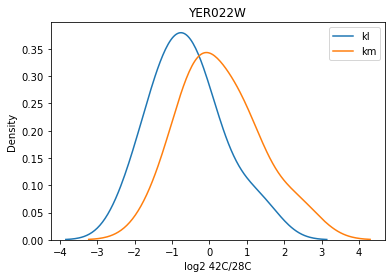

In [40]:
plot_fitness_ratios_by_gene('YER022W')